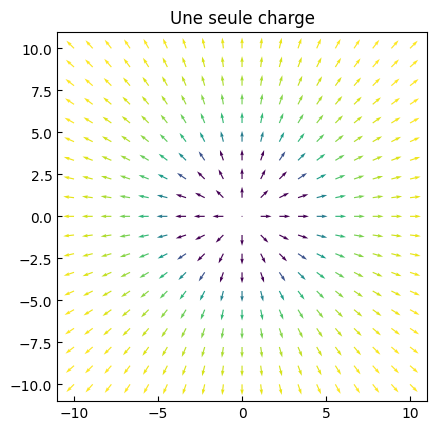

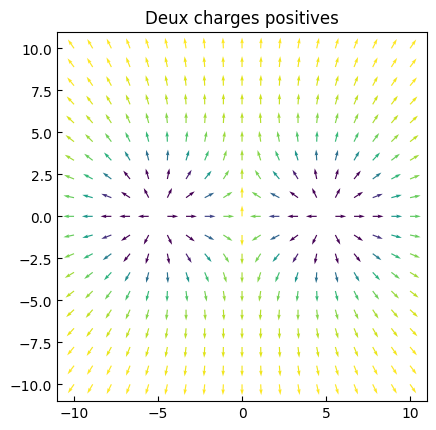

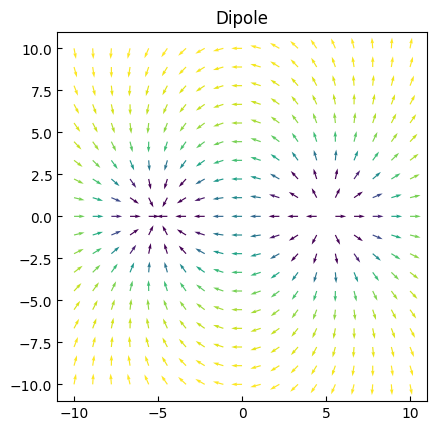

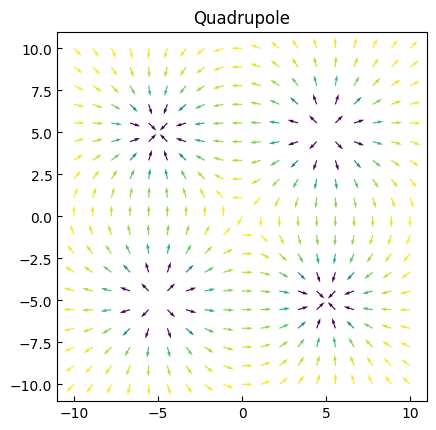

In [1]:
import matplotlib.pyplot as plt
import numpy as np

class SurfaceDomain:
    def __init__(self, size=None, radius=None, M=5, N=19, X=None, Y=None):
        """
        Le domain par défaut va de -10 a 10 en X et Y, et discrétise
        avec N=19 points. L'utilisateur peut quand même fournir ses np.array
        X et Y, déjà calculés d'avance.
        """
        if size is not None:
            X, Y = self.create_square_meshgrid(size, N)
        elif radius is not None:
            X, Y = self.create_polar_meshgrid(radius, M, N)
        elif X is None or Y is None:
            X, Y = self.create_square_meshgrid()
        else:
            raise ValueError("Vous devez fournir size, radius ou X et Y")

        if len(X) != len(Y):
            raise ValueError("Les composantes X et Y doivent avoir le meme nombre d'éléments")

        self.X = X
        self.Y = Y # et d'utiliser les @property accessors ou les fonctions

    def xy_mesh(self, xo=0, yo=0):
        """
        Les np.arrays X,Y du meshgrid, mais relatif à l'origine (xo, yo).
        Ceci permet d'utiliser directement les valeurs pour le calcul du
        champ d'une charge unique.

        Par défaut, l'origine est à (0,0)
        """
        X,Y = self.X-xo, self.Y-yo
        return X,Y

    def rphi_mesh(self, xo=0, yo=0):
        """
        Les np.arrays en coordonnées polaires, R,PHI du meshgrid, mais
        relatif à l'origine (xo, yo).
        Ceci permet d'utiliser directement les valeurs pour le calcul du
        champ d'une charge unique.

        Par défaut, l'origine est à (0,0)
        """
        X,Y = self.xy_mesh(xo, yo)
        return np.sqrt(X*X+Y*Y), np.arctan2(Y, X)

    def set_square_meshgrid(self, size=20, N=19):
        """
        Fonction pour assigner un domaine XY rapidement
        """
        self.X, self.Y = self.create_square_meshgrid(size, N)

    def set_polar_meshgrid(self, radius=20, M=5, N=36):
        """
        Fonction pour assigner un domaine RPHI rapidement
        """
        self.X, self.Y = self.create_polar_meshgrid(radius, M, N)

    def create_square_meshgrid(self, size=20, N=19):
        """
        Fonction pour créer un domaine XY rapidement
        """
        x = np.linspace(-size/2,size/2, N)
        y = np.linspace(-size/2,size/2, N)
        return np.meshgrid(x,y)

    def create_polar_meshgrid(self, radius=20, M=5, N=36):
        """
        Fonction pour créer un domaine XY a symétrie polaire rapidement
        On conserve quand meme tout dans les vecteurs X et Y, mais la
        symétrie sera polaire.
        """
        r = np.linspace(radius/M, radius, M)
        phi = np.linspace(0, 2*np.pi, N)
        R, PHI = np.meshgrid(r, phi)
        X = R*np.cos(PHI)
        Y = R*np.sin(PHI)
        return X, Y

class VectorField2D:
    def __init__(self, surface=None, U=None, V=None):
        """
        On accepte la surface ou on en crée une par défaut. L'utilisteur peut
        fournir les composantes d'un champ U, V mais sinon, le champ est
        initialisé à 0,0 partout.
        """
        if surface is None:
            surface = SurfaceDomain()

        self.domain = surface

        if U is None or V is None:
            U, V = self.create_null_field_components()

        self.U = U
        self.V = V

        self.quiver_axes = None

        self.validate_arrays() # Avant d'aller plus loin, nous voulons un champ valide


    @property
    def field_magnitude(self):
        return np.sqrt(self.U*self.U+self.V*self.V)

    def create_null_field_components(self):
        X,Y = self.domain.xy_mesh()
        return X*0, X*0 # C'est un truc pour avoir rapidement une liste de la meme longueur avec des zeros

    def create_single_charge_field_components(self, xo=0, yo=0, q=1):
        R, PHI = self.domain.rphi_mesh(xo, yo)

        """
        Lors du calcul, on pourra se retrouver, parfois, avec R==0 (a l'origin), et donc 1/(R*R)
        sera infini. Il est possible d'éviter les messages d'erreurs avec cette
        commande with np.errstate() pour la division par zéro.
        La methode add_field_components() devra par la suite filtrer les valeurs infinies
        """

        with np.errstate(divide='ignore', invalid='ignore'):
            U, V = q*np.cos(PHI)/(R*R), q*np.sin(PHI)/(R*R)
        return U,V

    def add_field_components(self, U, V):
        """
        On identifie les valeurs U et V qui sont valides, et on assigne
        seulement ces indices avec:self.U[u_valid] += ...
        """
        u_valid = np.isfinite(U)
        v_valid = np.isfinite(V)

        self.U[u_valid] += U[u_valid]
        self.V[v_valid] += V[v_valid]
        self.validate_arrays()

        self.quiver_axes = None # Nous avons changé le champ, la figure n'est plus valide

    def add_single_charge(self, xo=0, yo=0, q=1):
        U, V = self.create_single_charge_field_components(xo, yo, q)
        self.add_field_components(U, V)

    def validate_arrays(self):
        if self.U is None or self.V is None:
            raise ValueError("Les composantes U et V du champ vectoriel ne sont pas assignées en tout point X et Y")

        if len(self.U) != len(self.V):
            raise ValueError("Les composantes U et V doivent avoir le meme nombre d'éléments")

        if np.isnan(self.U).any():
            raise ValueError('U is invalid')
        if np.isinf(self.U).any():
            raise ValueError('U has infinity')
        if np.isnan(self.V).any():
            raise ValueError('V is invalid')
        if np.isinf(self.V).any():
            raise ValueError('V has infinity')

    def display(self, use_color=True, title=None):
        self.validate_arrays()

        if self.quiver_axes is None:
            self.quiver_axes = plt.subplot(1,1,1)
            self.quiver_axes.tick_params(direction="in")

        self.quiver_axes.cla()

        X,Y = self.domain.xy_mesh()

        if use_color:
            """
            Au lieu de prendre la longueur de la fleche pour représenter
            la force du champ, je garde les fleches de la meme longueur
            et je les colore en fonction de la force du champ.

            Je dois gérer lorsque la longueur du vecteur est nulle, car on
            tente de normaliser un vecteur nul, ce qui n'est pas possible.
            Cependant, si je mets lengths == 1, j'aurai simplement U/length == 0
            et V/lengths == 0 donc ce sera ok.
            """

            lengths = self.field_magnitude

            null_field = (lengths == 0)
            lengths[null_field] = 1

            U = self.U/lengths
            V = self.V/lengths


            """
            Les couleurs sont biaisées car il y a souvent des valeurs tres grandes.
            PLutot que de normaliser sur la plus grande valeurs, je limite
            les valeurs entre les percentiles 10-90 et je normalise la longueur des fleches.
            Ca fait plus beau.
            """
            percentile_10th = np.percentile(lengths, 10)
            percentile_90th = np.percentile(lengths, 90)
            colors = np.clip(lengths, a_min=percentile_10th, a_max=percentile_90th)

            """
            Et finalement, j'ai compris que les unités du champ sont plus simple
            lorsqu'on prend relatif a la grandeur du graphique: la largeur
            de la fleche sera aussi mieux adaptée independamment des unités.
            """
            self.quiver_axes.quiver(X, Y, U, V, colors, cmap="viridis_r")
        else:
            self.quiver_axes.quiver(X, Y, self.U, self.V)

        self.quiver_axes.set_aspect('equal')
        plt.title(title)
        plt.show()
        self.quiver_axes = None

if __name__ == "__main__": # C'est la façon rigoureuse d'ajouter du code après une classe
    single_charge_field = VectorField2D() # Le domaine par défaut est -10 a 10 avec 19 points par dimension
    single_charge_field.add_single_charge(xo=0, yo=0, q=1)
    single_charge_field.display(use_color=True, title="Une seule charge")

    two_charges_field = VectorField2D()
    two_charges_field.add_single_charge(xo=5, yo=0, q=1)
    two_charges_field.add_single_charge(xo=-5, yo=0, q=1)
    two_charges_field.display(use_color=True, title="Deux charges positives")

    dipole_field = VectorField2D()
    dipole_field.add_single_charge(xo=5, yo=0, q=1)
    dipole_field.add_single_charge(xo=-5, yo=0, q=-1)
    dipole_field.display(use_color=True, title="Dipole")

    quadrupole_field = VectorField2D()
    quadrupole_field.add_single_charge(xo=5, yo=5, q=1)
    quadrupole_field.add_single_charge(xo=-5, yo=5, q=-1)
    quadrupole_field.add_single_charge(xo=5, yo=-5, q=-1)
    quadrupole_field.add_single_charge(xo=-5, yo=-5, q=1)
    quadrupole_field.display(use_color=True, title="Quadrupole")

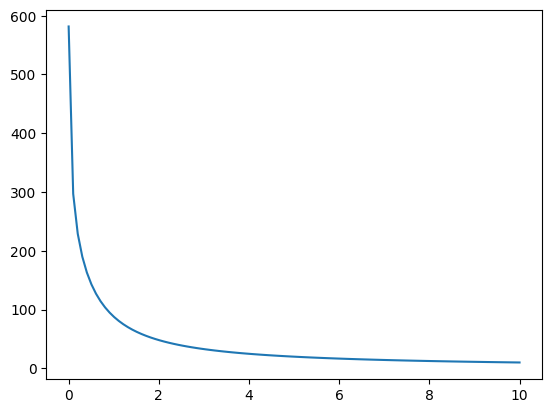

In [9]:
import numpy as np
import matplotlib.pyplot as plt

"""
Calculer le champ sur une ligne
===============================

J'ai un ligne de charge
"""

densite_charge = 1
L = 1           # Demi-grandeur de la ligne en y
N = 100         # Nombre de sources discrètes sur la ligne
Y = np.linspace(-L, L, N) # Valeurs en y sur la ligne

distance = 10*L
M = 100

X = np.linspace(0, distance, M)
V = np.zeros(M) # Potentiel sur la ligne x

for i, x in enumerate(X):
  for y in Y:
    r = np.sqrt(x*x+y*y)
    V[i] += densite_charge/r

plt.plot(X, V)
plt.show()

# Les données numériques
#for line in zip(line_field.domain.Y[centered], line_field.V[centered]):
#    print(*line)